# Model Preparation Challenge
This is an assignment for my thinkful data science course - "Model_Preparation_Challenge"
Raj Prasad
May 2019


[html version](https://daddyprasad5.github.io/Model_Preparation_Challenge.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/Model_Preparation_Challenge.ipynb) - with all the code exposed in an interactive notebook

My goal in this challenge is to find the factors that affect life expectancy. 

In [1]:
#imports
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
import scipy.stats as stats

%matplotlib inline

In [2]:
#data load
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

le_raw = pd.read_sql_query('select * from lifeexpectancy',con=engine)
le = le_raw.copy()
# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
le.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [4]:
le.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [5]:
le.describe(include=['O'])

,Country,Status
count,2938,2938
unique,193,2
top,Denmark,Developing
freq,16,2426


Data Types: 

3 categorical variables: 
 Nominal: Country, Status (developing, developed)
 Ordinal: Year

19 continuous (all are ratio) 


In [6]:
#Categorical values - count of each level
#Don't see anything unreasonable. 
# cats = ["Country", "Status", "Year"]
# for cat in cats: print(le[cat].unique())

In [7]:
#fix column headers
le_raw.columns = le_raw.columns.str.strip()
le.columns = le.columns.str.strip()

In [8]:
#fill missing values
"""
There are significant numbers of missing values in these columns: 
Hepatitis B, GDP, Total Expenditure, Alcohol, 
Income composition of resourcs, Schooling. 

Fill process: 
1. Use interpolation with each country (data is already sequenced 
by country (ascending) then year (descending). 
2. Fill with average value for that country across all years
3. Fill with average across all countries for that year
"""

col_list = ['Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling']

countries = le["Country"].unique()

#interpolate within country, sequenced by year
for c in countries:
     le.loc[le["Country"] == c, col_list] = le.loc[le["Country"] == c, col_list].interpolate()

#fill with the average for the country across all years
for col in col_list:
    for c in countries:
        country_average = le[le["Country"] == c][col].mean()
        le.loc[(le['Country']==c) & (le[col].isnull()), col] = country_average
        
#any remaining blanks indicate countries that have no data for any
#year for that variable

def test_nulls(df):
    n = len(df)
    cols = df.columns
    num_null = [len(df[df[col].isnull()]) / n for col in df]
    num_null_raw = [len(le_raw[le_raw[col].isnull()]) / n for col in df]
    null_df = pd.DataFrame([cols, num_null_raw, num_null]).transpose()
    null_df.columns = ["col", "# null raw", "# null post filling"]
    print(null_df)

test_nulls(le)



                                col  # null raw # null post filling
0                           Country           0                   0
1                              Year           0                   0
2                            Status           0                   0
3                   Life expectancy  0.00340368          0.00340368
4                   Adult Mortality  0.00340368          0.00340368
5                     infant deaths           0                   0
6                           Alcohol   0.0660313          0.00578625
7            percentage expenditure           0                   0
8                       Hepatitis B    0.188223           0.0490129
9                           Measles           0                   0
10                              BMI   0.0115725           0.0115725
11                under-five deaths           0                   0
12                            Polio  0.00646698                   0
13                Total expenditure   0.0769231 

## Missing Values

There are many missing values. I followed these steps to fill missing values:

1. I've first filled missing values with interpolation, with the data sequenced by country and then year.  This filled a small percentage of the missing values.  
2. The remaining missing values did not have data for that country & variable for the before / after years.  The next best fill strategy was to fill with the mean for a given country across all years.  This filled a small portion of the remaining missing values. 
3. A large portion of all the missing values in the raw data still remained missing.  These values are for countries with no data for the given variable across all years.  Some variables had no data for a large percentage (>5%) of countries across all years: 

* population (22%)
* GDP (14%)
* Income composition of resources (6%)
* Schooling (6%)
* Hepatitis B (5%)

I had several options for dealing with these missing values: 
* *Drop the rows.* Dropping the rows that contain these nulls would drop a lot of countries entirely out of the analysis.  Those countries do have a lot of meaningful data in other variables. 
* *Fill with a mean or median across all countries for the given year.*  Filling a large % of values could distort findings, especially in the case of GDP and Population. 
* *Drop the columns*  Dropping the column entirely only makes sense if the other options would lead to distortions in the analysis.  

I dropped the columns with the most missing data (GDP and population) from the analysis entirely, and filled the others with averages for each year across all the countries.  

In [9]:
#Dropping GDP and Pop, filling the remainder with annual average across all countries

#Drop GDP and population
le.drop(columns=["GDP", "Population"], inplace=True)

col_list.remove("GDP")
col_list.remove("Population")

#Fill with annual average across all countries
#DON'T KNOW WHY THIS ISN'T FILLING ALL REMAINING NULLS#
#df[(df['A']==12.0) & (df['D'].isnull())] = 400

years = le["Year"].unique()
for col in col_list:
    for y in years:
        le.loc[(le['Year']==y) & (le[col].isnull()), col] = le[le["Year"] == y][col].mean()
        #le[(le["Year"] == y) & (le[col].isnull())][col] = le[le["Year"] == y][col].mean()

#Filling with overall average until I can figure out why the above isn't workign
# for col in col_list:
#         le[col].fillna(le[col].mean(), inplace=True)
        
#affirm that there are no more missing values
test_nulls(le)

                                col  # null raw # null post filling
0                           Country           0                   0
1                              Year           0                   0
2                            Status           0                   0
3                   Life expectancy  0.00340368                   0
4                   Adult Mortality  0.00340368                   0
5                     infant deaths           0                   0
6                           Alcohol   0.0660313                   0
7            percentage expenditure           0                   0
8                       Hepatitis B    0.188223                   0
9                           Measles           0                   0
10                              BMI   0.0115725                   0
11                under-five deaths           0                   0
12                            Polio  0.00646698                   0
13                Total expenditure   0.0769231 

In [10]:
# describe of data with missing values filled
le.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.00000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.231777,164.741882,30.303948,4.60024,738.251295,75.832054,2419.592240,38.323713,42.035739,82.307692,5.920979,82.075221,1.742103,4.839464,4.870027,0.627686,11.993407
std,4.613841,9.508362,124.083816,117.926501,4.02767,1987.914858,27.928179,11467.272489,19.929396,160.445548,23.636677,2.455677,23.917022,5.077785,4.394616,4.482803,0.205212,3.268724
min,2000.000000,36.300000,1.000000,0.000000,0.01000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.200000,74.000000,0.000000,0.93000,4.685343,67.000000,0.000000,19.400000,0.000000,77.000000,4.280000,78.000000,0.100000,1.600000,1.600000,0.504250,10.300000
50%,2008.000000,72.000000,144.000000,3.000000,3.77500,64.912906,88.000000,17.000000,43.000000,4.000000,93.000000,5.760000,93.000000,0.100000,3.400000,3.400000,0.673000,12.300000
75%,2012.000000,75.600000,227.000000,22.000000,7.67750,441.534144,96.000000,360.250000,56.100000,28.000000,97.000000,7.430000,97.000000,0.800000,7.100000,7.200000,0.772000,14.100000
max,2015.000000,89.000000,723.000000,1800.000000,17.87000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.600000,99.000000,50.600000,27.700000,28.600000,0.948000,20.700000


### Outliers:

There are outliers (at 3 standard deviation Z score threshold) for every continuous variable but one (BMI).  In some cases there are clear measurement errors - where the values don't make sense given the meaning of the variable.  In other cases the values are out-of-wack with other sources of the same data.  

Extreme values can dramatically impact the analysis by, for example, pulling means far from the median or growing the standard deviations.  In cases where there is likely measurement error, I've modified the observiations through winsorization.   In cases where there are statistically extreme values, but I have no reason to suspect measurement error, I prefer a log transformation, relying on winsorization only for variables with zero values.  

Here I've outlined each concern by issue type, along with how I've altered the data to reduce the number and impact of outliers.  

**Measurement errors:** 

Issue: Infant mortality per thousand observations is far too high in many cases (e.g. greater than 1000).    

Issue: Under-five deaths per 1000 births are far too high in many cases. the highest rate in 2017 per the world bank is 127 (Somalia).  
ACTION: I have windsorized on the high side. 

**other extreme observations:**
These are extreme values statistically, but I have no semantic reason to distrust the measurement. 

Issue: a variable has just a few outliers (beyond 3 standard deviations) and they are just beyond that thresshold: 
- Life expectancy
- Hepatitis B
- Alcohol

Action: Do nothing. Acknowledge the outliers but accept them as reasonable, actual observations that are unlikely to impact the analysis. 

Issue: outliers on the high side, all values postive & non-zero:
- Adult Mortality
- Alcohol
- Measles
- Total Expenditure
- HIV Aids
- thinness 1-19
- thinness 1-5

Action: take the log of these measures

Issue: outliers on the low side, all values positive & non-zero:
- Polio
- Diptheria

Action: take the log.

Issue: Outliers high, and variable has negative or zero-values:

- Infant deaths
- Measles
- Under 5 deaths
- Percentage expenditure

Action: winsorize high

Issue: Outliers low and high, and variable has negative or zero-values:

- schooling

Action: winsorize low and high

Issue: Outliers low and high, and variable has negative or zero-values:

- income composition

Action: winsorize low

**Metadata likely inaccurate**

Issues: 
* Measles is defined as reported cases per 1000 population.  But the average is 2419 (i.e. >1000).  I will assume the definition is wrong.
* Mean body mass index is extremely high.  WHO (purported source of this data) says obese is >25 for an adult mean.  The mean for these countries (for their entire populations) being over 40 is not reasonable). I will assume that the metric is different than a typical BMI metric but the same general meaning. 
* Schooling is defined as "Number of years of Schooling(years)".  These are too high by that definition.  Compare to the UN Human Development Reports.  I suspect the definition is inaccurate - perhaps it's the average oldest age at which school was attended? 

Action: Assume that the metadata is incorrect and proceed. 

### Other Data Quality Concers

**Unclear meaning: **

Issues: 
* Percentage Expenditure is the ratio of total expenditure on health as a percentage of GDP per Capita.  Strange combination - why not take the proporiton of two per capita measures or two total measures? 

* Unclear what "income comosition of resources" means.  Kaggle metatdata is difficult to decipher: "Human Development Index in terms of income composition of resources (index ranging from 0 to 1"

Action: I will use these variables cautiously.



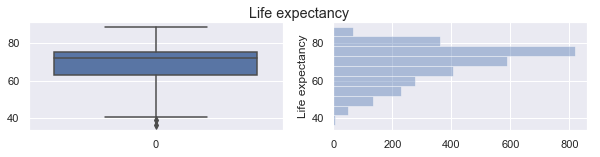

For column Life expectancy...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 2 at threshold 3




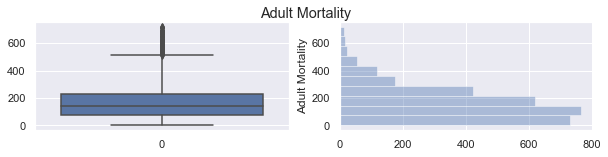

For column Adult Mortality...
Number of outliers (up-side) is: 40 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




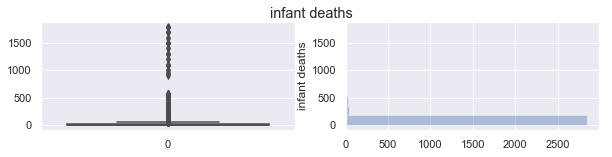

For column infant deaths...
Number of outliers (up-side) is: 37 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




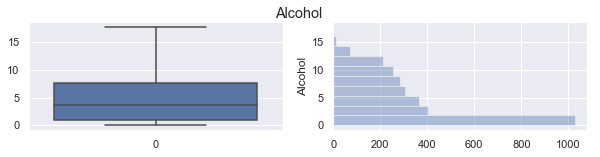

For column Alcohol...
Number of outliers (up-side) is: 3 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




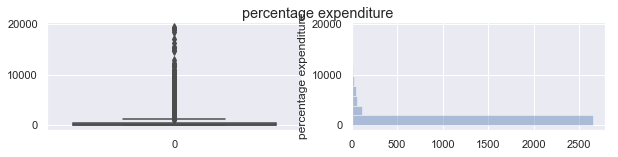

For column percentage expenditure...
Number of outliers (up-side) is: 84 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




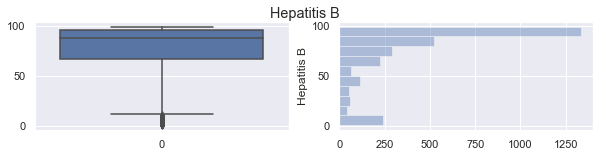

For column Hepatitis B...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




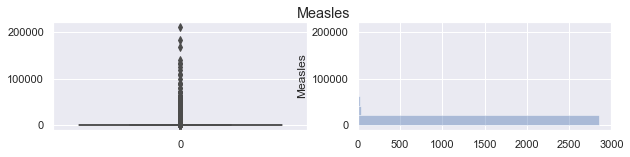

For column Measles...
Number of outliers (up-side) is: 48 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




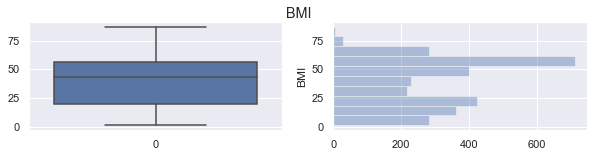

For column BMI...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




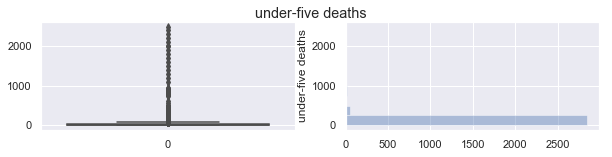

For column under-five deaths...
Number of outliers (up-side) is: 34 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




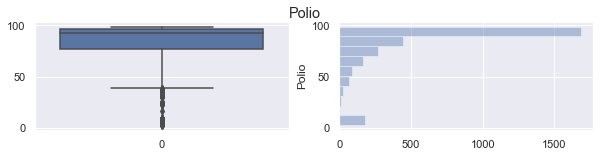

For column Polio...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 178 at threshold 3




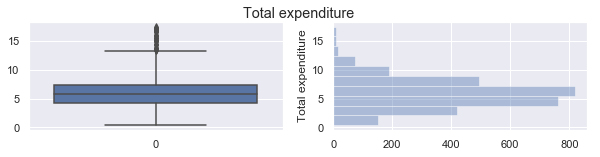

For column Total expenditure...
Number of outliers (up-side) is: 27 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




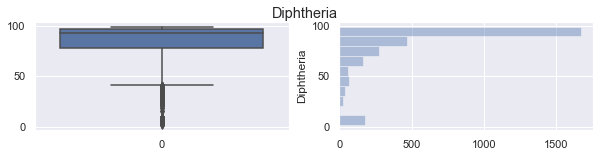

For column Diphtheria...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 176 at threshold 3




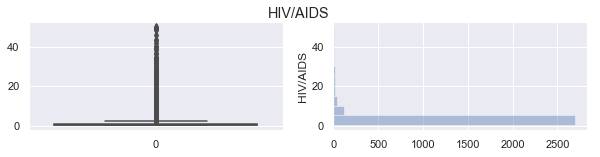

For column HIV/AIDS...
Number of outliers (up-side) is: 69 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




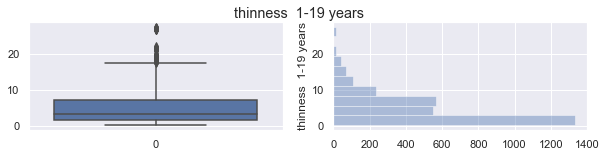

For column thinness  1-19 years...
Number of outliers (up-side) is: 54 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




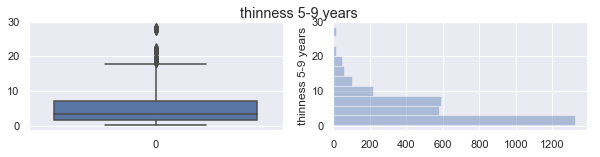

For column thinness 5-9 years...
Number of outliers (up-side) is: 57 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




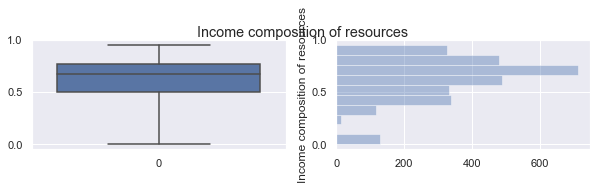

For column Income composition of resources...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 130 at threshold 3




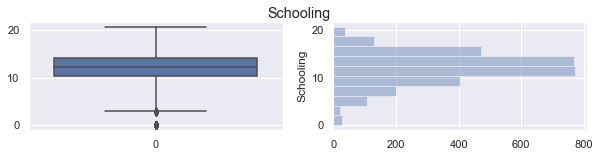

For column Schooling...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 28 at threshold 3




In [11]:
#find outliers

sns.set()

def z_count(df, col, threshold):
    """
    prints the number of observatins for each of the z scores 
    between the min and max (inclusive)
    """
    
    print("For column {}...".format(str(col)))
    z_scores = zscore(df[col])
    num_outliers_up = len(np.where(z_scores > threshold)[0])
    num_outliers_down = len(np.where(z_scores < threshold*-1)[0])
    print("Number of outliers (up-side) is: {} at threshold {}".format(num_outliers_up, threshold))
    print("Number of outliers (down-side) is: {} at threshold {}".format(num_outliers_down, threshold))
    print("\n")

col_list = ['Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling']

for col in col_list:
    fig = plt.figure(figsize=(10, 2))
    fig.suptitle(col)
    plt.subplot(1,2,1)
    sns.boxplot(data=le[col], whis=1.9)
    plt.subplot(1,2,2)
    sns.distplot(le[col], bins = 10, kde=False, vertical=True)
    plt.show()
    z_count(le, col, 3)



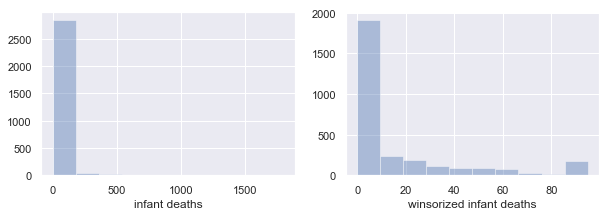

For column winsorized infant deaths...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




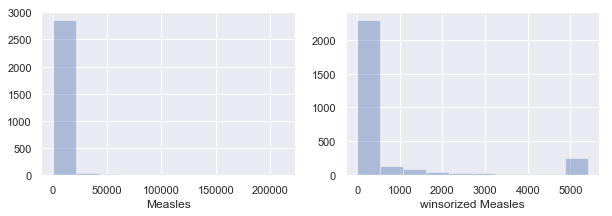

For column winsorized Measles...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




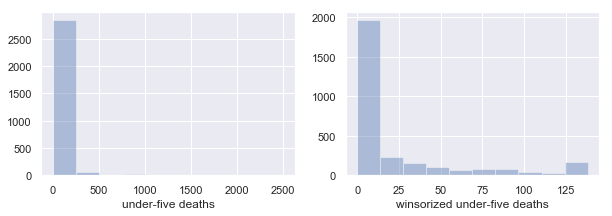

For column winsorized under-five deaths...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




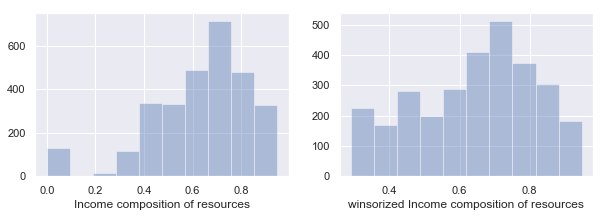

For column winsorized Income composition of resources...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




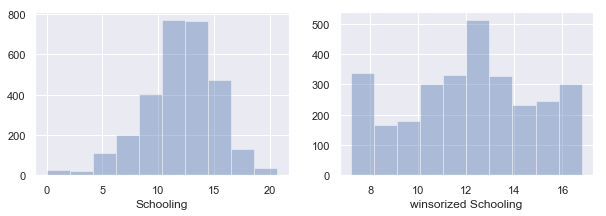

For column winsorized Schooling...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




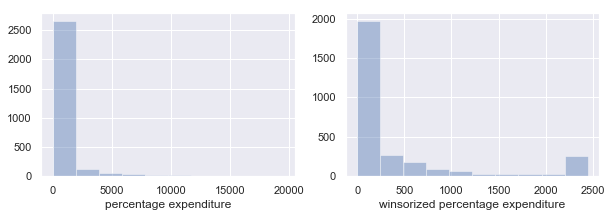

For column winsorized percentage expenditure...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




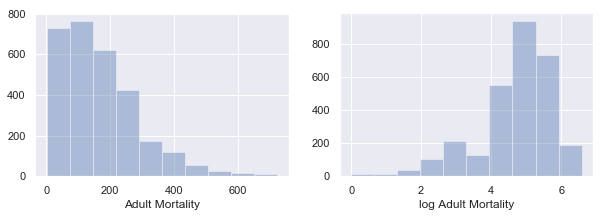

For column log Adult Mortality...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 30 at threshold 3




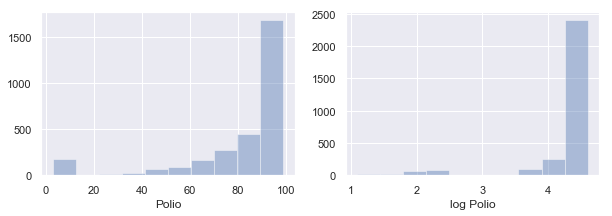

For column log Polio...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 178 at threshold 3




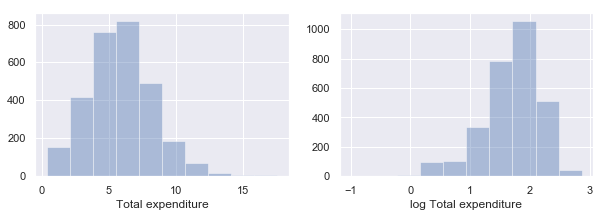

For column log Total expenditure...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 33 at threshold 3




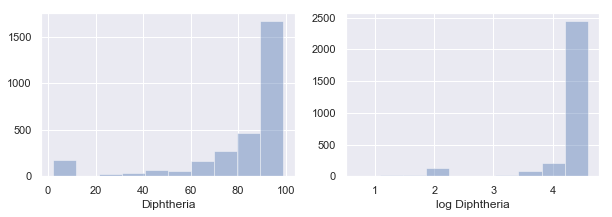

For column log Diphtheria...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 176 at threshold 3




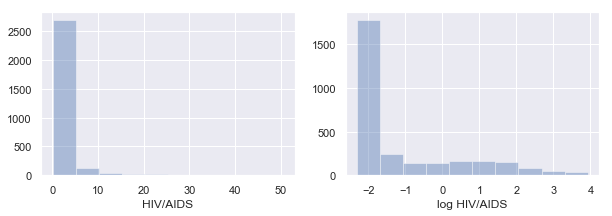

For column log HIV/AIDS...
Number of outliers (up-side) is: 13 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




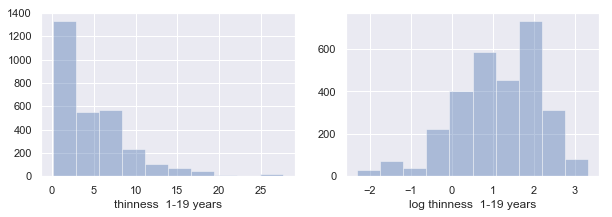

For column log thinness  1-19 years...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 28 at threshold 3




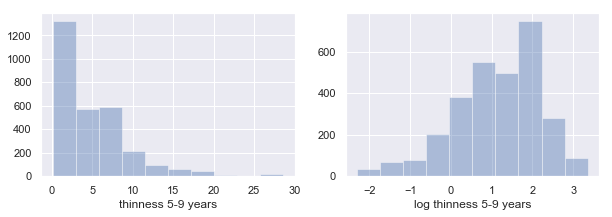

For column log thinness 5-9 years...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 37 at threshold 3




In [12]:
#manage outliers
#note that even after log transformation, 
#several variables still have some outliers. I'm leaving those
#as they don't seem to be due to measurement error. 

zero_outs = ['infant deaths', 'Measles', 'under-five deaths',
             'Income composition of resources', 'Schooling', 
            'percentage expenditure']
non_zero_outs = ['Adult Mortality', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'thinness  1-19 years',
       'thinness 5-9 years']

#Windosorize for both measurement error and for outliers of variables with zero values
le["winsorized infant deaths"] = winsorize(le["infant deaths"], (0, 0.05))
le["winsorized Measles"] = winsorize(le["Measles"], (0, 0.08))
le["winsorized under-five deaths"] = winsorize(le["under-five deaths"], (0, 0.05))
le["winsorized Income composition of resources"] = winsorize(le["Income composition of resources"], (0.05, 0))
le["winsorized Schooling"] = winsorize(le["Schooling"], (0.08, 0.05))
le["winsorized percentage expenditure"] = winsorize(le["percentage expenditure"], (0.0, 0.08))

#log columns with outliers with all positive, non-zero values
for col in non_zero_outs: 
    le["log {}".format(col)] = np.log(le[col])


for col in zero_outs: 
    plt.figure(figsize=(10, 3))
    plt.subplot(1,2,1)
    sns.distplot(le[col], bins = 10, kde=False)
    colname = "winsorized {}".format(col)
    plt.subplot(1,2,2)
    sns.distplot(le[colname], bins = 10, kde=False)
    plt.show()
    z_count(le, colname, 3)
for col in non_zero_outs:
    plt.figure(figsize=(10, 3))
    plt.subplot(1,2,1)
    sns.distplot(le[col], bins = 10, kde=False)
    plt.subplot(1,2,2)
    colname = "log {}".format(col)
    sns.distplot(le[colname], bins = 10, kde=False)
    plt.show()
    z_count(le, colname, 3)




### Univariate Analysis

The distributions of all of the variables are shown.  Above, find the distributions of transformed variables, alongside alongside it's pre-transformed version.  

Below find the distributions of variables that are not transformed. 

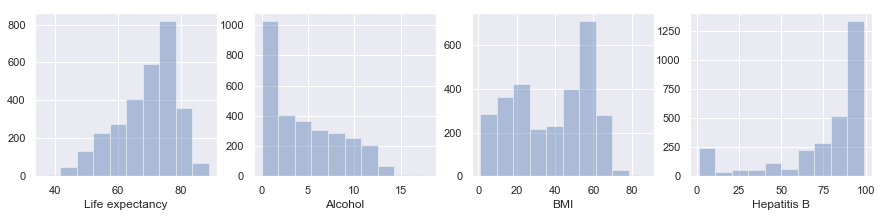

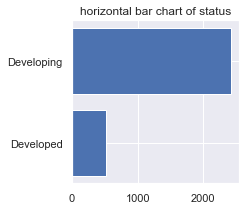

In [13]:
#un-transformed variable distributions

#continuous
untransf = ['Life expectancy', 'Alcohol', 'BMI', 'Hepatitis B']

i=1
plt.figure(figsize=(15, 3))
for col in untransf:
    plt.subplot(1,4,i)
    sns.distplot(le[col], bins = 10, kde=False)
    i += 1
plt.show()

# bar chart of categorical variables
plt.figure(figsize=(3,3))
plt.barh(le.groupby("Status")["Status"].count().index, 
        le.groupby("Status")["Status"].count())
plt.title("horizontal bar chart of status")

plt.show()

### Correlation with Life Expectancy

These variables have a statistically significant relationship with life expectancy: 

Status: The two levels of status (developing and developed) have different mean life expectancies that are stasticially significant at p <0.05. 



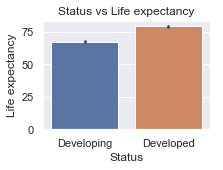

t-test between groups Developing and Developed is significant:  p = 1.778895704879565e-170:


In [14]:
def cat_to_cont(df, cat, cont, threshold):
    """creates a barplot and conducts t-test 
    for a categorical to continuous relationship"""

    #group by
    unique_vals = df[cat].unique()
    grouped_df = df[[cat, cont]].groupby(cat).mean()

    #barplot
    plt.figure(figsize=(3, 2))
    sns.barplot(df[cat], df[cont])
    plt.title("{} vs {}".format(cat, cont))
    plt.show()

    #t-test
    for i in range(0, len(unique_vals)):
        for j in range(i+1, len(unique_vals)):
            t, p = stats.ttest_ind(
                df[df[cat]==unique_vals[i]][cont], 
                df[df[cat]==unique_vals[j]][cont])
            if p < threshold: 
                print("t-test between groups {0} and {1} is significant:  p = {2}:"
                      .format(unique_vals[i], unique_vals[j], p))
                
cat_to_cont(le, "Status", "Life expectancy", .05)

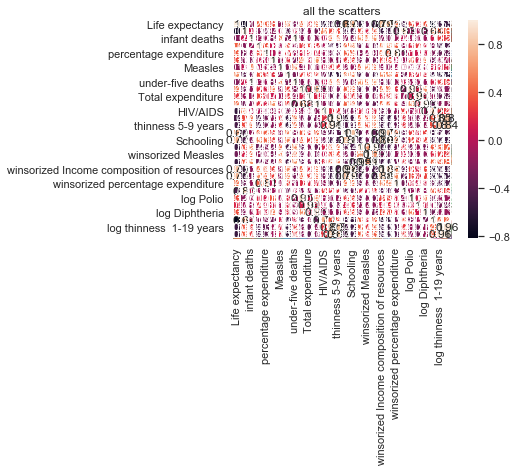

In [19]:
#note I'm using pre-transformed variables first, for ease of semantics

col_list = ['Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure',
       'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio',
       'Total expenditure', 'Diphtheria', 'HIV/AIDS',
       'thinness  1-19 years', 'thinness 5-9 years',
       'Income composition of resources', 'Schooling',
       'winsorized infant deaths', 'winsorized Measles',
       'winsorized under-five deaths',
       'winsorized Income composition of resources',
       'winsorized Schooling', 'winsorized percentage expenditure',
       'log Adult Mortality', 'log Polio', 'log Total expenditure',
       'log Diphtheria', 'log HIV/AIDS', 'log thinness  1-19 years',
       'log thinness 5-9 years']

def cont_to_cont(conts, df, title):
    """
    plots scatters and correlation matrix heat map for the list of 
    continuous variables in the dataframe.  
    title arg is the title for the heatmap
    """
    #plt.figure(figsize=(18,5))
    axes_cnt = len(conts)
    axes_num = 1
    for i in range(0, len(conts)):
        for j in range(i+1, len(conts)):
            #scatter plot
            #plt.subplot(1, axes_cnt, axes_num)
            plt.scatter(df[conts[i]], df[conts[j]], alpha=.2)
            plt.title("{0} vs {1}".format(conts[i], conts[j]))
            axes_num += 1
            plt.show

    #plt.show()

    #correlation coefficients
    corr_coeffs = df[conts].corr()

    sns.heatmap(corr_coeffs, square=True, annot=True, linewidths=.5)
    plt.title(title)

cont_to_cont(col_list, le, "all the scatters")